# Crowd Count Using MCNN

An implementation of CVPR2016 paper [Single-Image Crowd Counting via Multi-Column Convolutional Neural Network](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhang_Single-Image_Crowd_Counting_CVPR_2016_paper.pdf)

**Note that some setting is changed for transfer learning setting**

This code use the pre-trained weight from this [github](https://github.com/uestcchicken/crowd-counting-MCNN)

We use Keras as an implementation **ONLY**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import scipy.io

In [2]:
ICANTEEN_TRAIN_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train/'
ICANTEEN_TRAIN_GT_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train_den/'
ICANTEEN_VAL_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val/'
ICANTEEN_VAL_GT_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val_den/'
ICANTEEN_TEST_PATH = 'icanteen_img/test/images/'
ICANTEEN_TEST_GT_PATH = 'icanteen_img/test/ground_truth/'

## Define Necessary Function

`preprocess_test` function recieves **PATH of images** and returns preprocessed data.
The preprocessing methods include:
- Loading images in B/W , `cv.imread(img,0)`
- Normalize Image, `(img-127.5)/128`

`preprocess_train` function receives **PATH of training images** and **PATH of density images**. It returns truple of loaded train image and density.

In [19]:
def preprocess_test(path):
    print('loading testing dataset...')
    img_names = os.listdir(path)
    img_num = len(img_names)
    img_names.sort()
    
    data = []
    i = 1
    for name in img_names:
        if i % 50 == 0:
            print('loaded:', i, '/', img_num)
        img = cv2.imread(path+name,0)
        norm_img = (img - 127.5) / 128
        data.append(norm_img)
        i += 1
    print('load data finished')
    return data

def preprocess_train(img_path, gt_path):
    print('loading training dataset...')
    img_names = os.listdir(img_path)
    img_num = len(img_names)
    img_names.sort()

    data = []
    density = []
    count = 1
    for name in img_names:
        if count % 100 == 0:
            print(count, '/', img_num)
        count += 1
        img = cv2.imread(img_path + name, 0)
        img = np.array(img)
        norm_img = (img - 127.5) / 128
        den = np.loadtxt(open(gt_path + name[:-4] + '.csv'), delimiter = ",")
        den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
        for i in range(len(den_quarter)):
            for j in range(len(den_quarter[0])):
                for p in range(4):
                    for q in range(4):
                        den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
        data.append(np.reshape(norm_img, [norm_img.shape[0], norm_img.shape[1], 1]))
        density.append(np.reshape(den_quarter, [den_quarter.shape[0], den_quarter.shape[1], 1]))
    data = np.array(data)
    density = np.array(density)
    print('load training data finished')
    return (data, density)
        
def get_ground_truth(path, verbose = 0):
    if verbose == 1:
        print('loading ground truth...')
    gt_names = os.listdir(path)
    gt_names.sort()
    gt = []
    i = 1
    for file in gt_names:
        mat = scipy.io.loadmat(path+file)
        gt.append(mat['image_info'][0][0][0][0][1][0][0])
        i += 1
    if verbose == 1:
        print('load ground truth finished')
    return gt

In [4]:
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD

def get_MCNN():    
    input1 = Input(shape=(None, None, 1)) 
    
    # S
    xs = Conv2D(24, kernel_size = (5,5), padding = 'same', activation = 'relu')(input1)   
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(48, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(24, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    
    # M
    xm = Conv2D(20, kernel_size = (7,7), padding = 'same', activation = 'relu')(input1)   
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(40, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(20, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = Conv2D(10, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    
    # L
    xl = Conv2D(16, kernel_size = (9,9), padding = 'same', activation = 'relu')(input1)   
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(32, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(16, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = Conv2D(8, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    
    x = concatenate([xm, xs, xl])
    out = Conv2D(1, kernel_size = (1,1), padding = 'same')(x)
    model = Model(inputs=input1, outputs=out)

    return model

Using TensorFlow backend.


In [5]:
model = get_MCNN()
model.load_weights('keras_weight/weights.h5')
len_layers = len(model.layers)
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 2 1000        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 2 624         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 1 1312        input_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [6]:
from keras.preprocessing.image import ImageDataGenerator

epochs = 2
batch_size = 4

In [7]:
train, train_den = preprocess_train(ICANTEEN_TRAIN_PATH, ICANTEEN_TRAIN_GT_PATH)
val, val_den = preprocess_train(ICANTEEN_VAL_PATH, ICANTEEN_VAL_GT_PATH)

loading training dataset...
100 / 252
200 / 252
load training data finished
loading training dataset...
load training data finished


In [8]:
model.compile(loss='mae',
              optimizer=Adam(0.0001),
              metrics=['mae'])

print('start training MCNN...')
history = model.fit(train, train_den,
                   validation_data = (val, val_den),
                   epochs = epochs, batch_size = batch_size,
                   verbose = 1)

start training MCNN...
Train on 252 samples, validate on 18 samples
Epoch 1/2
252/252 [==============================] - 4s 15ms/step - loss: 0.0019 - mean_absolute_error: 0.0019 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 2/2
252/252 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 0.0018 - val_mean_absolute_error: 0.0018


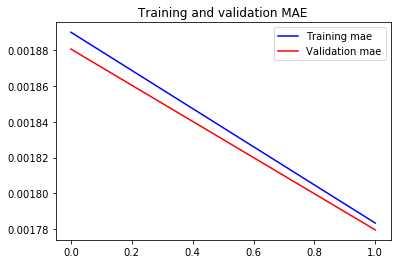

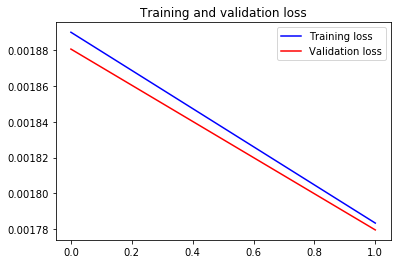

In [9]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(mae))
 
plt.plot(epochs, mae, 'b', label='Training mae')
plt.plot(epochs, val_mae, 'r', label='Validation mae')
plt.title('Training and validation MAE')
plt.legend()
 
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [10]:
data = preprocess_test(ICANTEEN_TEST_PATH)

loading testing dataset...
load data finished


In [11]:
def test_model(model, gt_path, verbose = 0):
    mae = 0
    mse = 0
    ground_truth = get_ground_truth(gt_path)
    pred = []

    initial_num = 31
    i = 0
    for d in data:
        inputs = np.reshape(d, [1, d.shape[0], d.shape[1], 1])
        outputs = model.predict(inputs)
        c_pre = round(np.sum(outputs))
        pred.append(c_pre)
        if verbose == 1:
            print('='*10+'IMG_'+str(i+initial_num)+'.jpg'+'='*10)
            print('IMG_'+str(i+initial_num),'predicted ', c_pre,'people')
            print('IMG_'+str(i+initial_num),'actual',ground_truth[i], 'people')
        mae += abs(ground_truth[i]-c_pre)
        mse += (ground_truth[i]-c_pre)**2
        if verbose == 1:
            print('ERROR:',abs(ground_truth[i]-c_pre))
            print('current MAE:',mae/(i+1))
            print('current MSE:',(mse/(i+1))**0.5)

        den = outputs.reshape(outputs.shape[1], outputs.shape[2])
        i += 1

    print('Mean Absolute Error:',mae/len(ground_truth))
    print('Mean Square Error:',math.sqrt(mse/len(ground_truth)))

    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(1,len(ground_truth)+1),ground_truth, marker='x')
    plt.plot(np.arange(1,len(ground_truth)+1),pred, marker='x')
    plt.xticks(np.arange(1,len(ground_truth)+1))
    plt.xlabel('Img no.')
    plt.ylabel('People')
    plt.legend(['ground truth', 'pred'])
    plt.title('Head counts Actual vs Predict')
    plt.show()
    
    return (pred, ground_truth)

Mean Absolute Error: 12.2666666667
Mean Square Error: 15.692885861646566


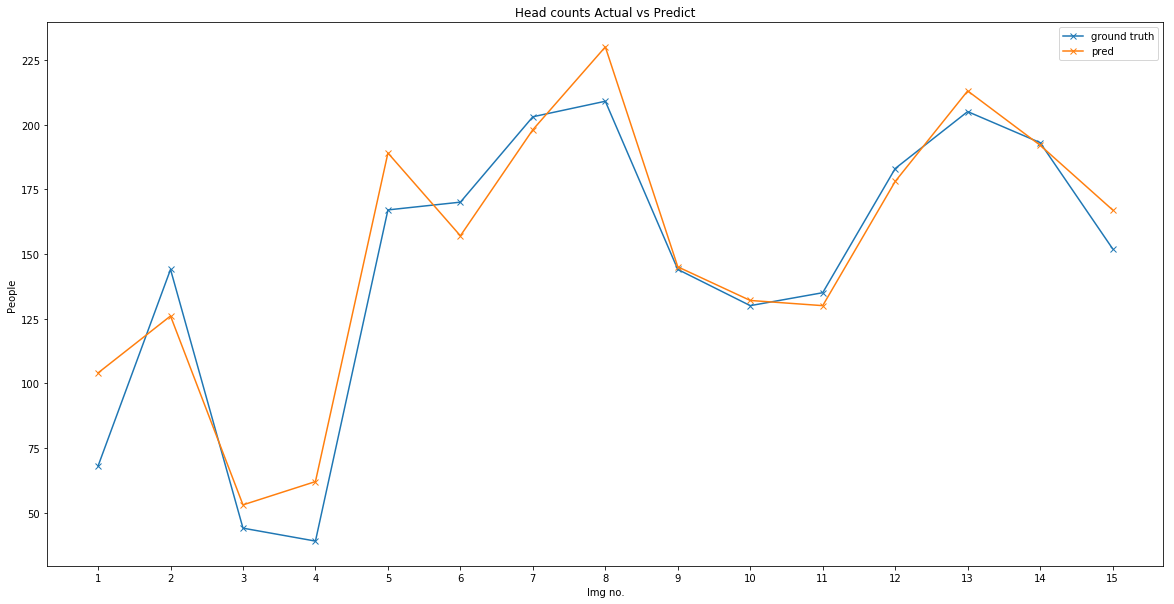

In [12]:
(pred, ground_truth) = test_model(model, ICANTEEN_TEST_GT_PATH)

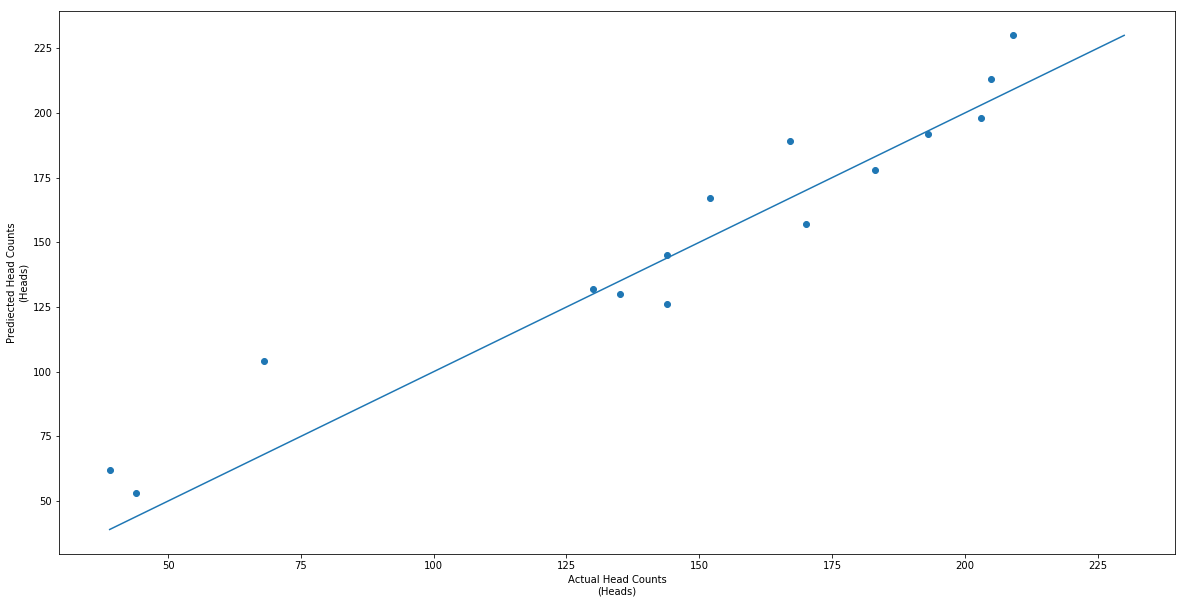

In [13]:
plt.figure(figsize=(20, 10))
min_plot = min(min(pred), min(ground_truth))
max_plot = max(max(ground_truth), max(pred))
plt.scatter(ground_truth, pred)
plt.plot(np.arange(min_plot,max_plot,0.01), np.arange(min_plot,max_plot,0.01))
plt.xlabel("Actual Head Counts\n(Heads)")
plt.ylabel("Prediected Head Counts\n(Heads)")
plt.show()

In [20]:
from sklearn.metrics import r2_score

ground_truth = get_ground_truth(ICANTEEN_TEST_GT_PATH)
r2 = r2_score(ground_truth, pred)
r = math.sqrt(r2)

In [21]:
print('r = {:.2f}'.format(r*100),'%')
print('r2 = {:.2f}'.format(r2*100),'%')

r = 95.68 %
r2 = 91.54 %


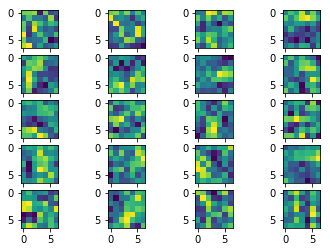

In [93]:
W = model.layers[1].get_weights()[0]
if len(W.shape) == 4:
    W = np.squeeze(W)
    for i in range(W.shape[len(W.shape)-1]):
        plt.subplot(5,4,i+1)
        plt.imshow(W[:,:,i])
#         plt.xticks([])
#         plt.yticks([])
    plt.show()

In [85]:
plot_conv_weights(model, 1)

IndexError: tuple index out of range

In [81]:
np.squeeze(model.layers[1].get_weights()[0]).shape

(7, 7, 20)